In [1]:
# here we define row as width, column as height

import numpy as np
from scipy.io import savemat

USE_REFERENCE = False

height = 128
width = 128

if USE_REFERENCE:
    ori_data = np.load('predict_dct_ref.npy')
    ori_data = ori_data.reshape(120,128,128)
else:
    ori_data = np.load('predict_k2k.npy')
    #ori_data = np.load('predict.npy')
    ori_data = ori_data.reshape(ori_data.shape[0], ori_data.shape[1], ori_data.shape[2])
print('shape of loaded data is: ' + str(ori_data.shape))

n_block = ori_data.shape[0]
width_block = ori_data.shape[1]
height_block = ori_data.shape[2]


shape of loaded data is: (120, 128, 128)


In [2]:
# show each block of the predicted data
# all in DCT coefficientsw
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage.io as imio
for block_id in np.arange(0,n_block, 10):
    implot = plt.imshow(ori_data[block_id, :, :])
    plt.title('block_id = ' + str(block_id))
    plt.colorbar()
    plt.show()
#print(ori_data[1,:,:])
savemat('k2k_predict_ori_data.mat',mdict={'k2k_predict_ori_data':ori_data})

In [3]:
from copy import deepcopy
from scipy.fftpack import dct, idct

def block_training_data(block_height=height,block_width=width):
    # read raw image data 
    rawpath = './training_raw/'
    raw_name_list = os.listdir(rawpath)
    raw_name_list.sort()
    rawarray = []
    for name in raw_name_list:
        if '.raw' in name:
            rawarray.append(name)
    # extract data from green sensor 
    global green1,green2
    green1 = []
    green2 = []
    green = []
    
    num = len(rawarray)
    for k in range(0,num):
        pop = np.fromfile(rawpath+rawarray[k],dtype=np.dtype('int16'))
        pop = pop[28672 : ]
        pop = np.reshape(pop,(2160,3840))
        a = pop[112:2160,0:2048]
        b = pop[111:2159,2048:3840]
        c = np.concatenate((b,a),axis=1)
        for i in range(0,8):
            for j in range(0,15):
                green1.append(c[block_height*2*i:block_height*2*(i+1):2,block_width*2*j:block_width*2*(j+1):2])
                green2.append(c[block_height*2*i+1:block_height*2*(i+1)+1:2,block_width*2*j+1:block_width*2*(j+1)+1:2])
        green.append(c[::2,::2])
    #green = np.array(np.array(green)/64,dtype='uint8')
    #save =  np.reshape(green,(green.shape[0],green.shape[1],green.shape[2],1))
    #np.save('./preprocess/unblocked.npy',save)
    green1 = np.array(np.array(green1)/64,dtype='uint8')
    green2 = np.array(np.array(green2)/64,dtype='uint8')
    return green1

def block_test_data(block_height=height,block_width=width):

    testpath = './test_raw/'
    test_name_list = os.listdir(testpath)
    test_name_list.sort()
    testarray = []
    for name in test_name_list:
        if '.raw' in name:
            testarray.append(name)
    num = len(testarray)
    for k in range(0,num):
        pop = np.fromfile(testpath+testarray[k],dtype=np.dtype('int16'))
        pop = pop[28672 : ]
        pop = np.reshape(pop,(2160,3840))
        a = pop[112:2160,0:2048]
        b = pop[111:2159,2048:3840]
        c = np.concatenate((b,a),axis=1)
        green1 = []
        green2 = []
        green = []
        for i in range(0,8):
            for j in range(0,15):
                green1.append(c[block_height*2*i:block_height*2*(i+1):2,block_width*2*j:block_width*2*(j+1):2])
                green2.append(c[block_height*2*i+1:block_height*2*(i+1)+1:2,block_width*2*j+1:block_width*2*(j+1)+1:2])
        green1 = np.array(np.array(green1)/64,dtype='uint8')
        green2 = np.array(np.array(green2)/64,dtype='uint8')
        green = c[::2,::2]
        green = np.array(np.array(green)/64,dtype='uint8')
        save = np.reshape(green,(green.shape[0],green.shape[1],1))
        #np.save('./testset/test1'+str(k)+'.npy',green1)
        return green1

def dct2D(x):
	tmp = dct(x, type=2, norm='ortho').transpose()
	return dct(tmp, type=2 ,norm='ortho').transpose()

def idct2D(x):
	tmp = idct(x, type=2 ,norm='ortho').transpose()
	return idct(tmp, type=2 ,norm='ortho').transpose()

def get_dct_co(x):
    """
    takes original pixel values as input
    generate the compressed and uncompressed DCT coefficients
    :param x: np.array of shape (n, 128, 128)
    :return: x(compressed), y(uncompressed)
    """
    num = int(x.shape[0])
    b = int(x.shape[1] / 8)
    x = np.array(x, dtype='float32') - 128
    y = deepcopy(x)
    q_matrix = np.array([
        16, 11, 10, 16, 24, 40, 51, 61,
        12, 12, 14, 19, 26, 58, 60, 55,
        14, 13, 16, 24, 40, 57, 69, 56,
        14, 17, 22, 29, 51, 87, 80, 62,
        18, 22, 37, 56, 68, 109, 103, 77,
        24, 35, 55, 64, 81, 104, 113, 92,
        49, 64, 78, 87, 103, 121, 120, 101,
        72, 92, 95, 98, 112, 100, 103, 99
    ]).reshape(8,8)
    for n in range(num):
        for i in range(b):
            for j in range(b):
                x[n, i*8:i*8+8, j*8:j*8+8] = \
                dct2D(x[n, i*8:i*8+8, j*8:j*8+8]) / q_matrix
    y = deepcopy(x)
    x = np.round(x)
    return x, y

def restore_dct_co(x):
    """
    takes DCT coefficients as input
    generate the corresponding jpeg values
    :param x: DCT coefficients of shape(n, 128, 128)
    :return: x: jpeg pixel generated from the input DCT coefficients
    """
    num = int(x.shape[0])
    b = int(x.shape[1] / 8)
    y = deepcopy(x)
    q_matrix = np.array([
        16, 11, 10, 16, 24, 40, 51, 61,
        12, 12, 14, 19, 26, 58, 60, 55,
        14, 13, 16, 24, 40, 57, 69, 56,
        14, 17, 22, 29, 51, 87, 80, 62,
        18, 22, 37, 56, 68, 109, 103, 77,
        24, 35, 55, 64, 81, 104, 113, 92,
        49, 64, 78, 87, 103, 121, 120, 101,
        72, 92, 95, 98, 112, 100, 103, 99
    ]).reshape(8,8)
    for n in range(num):
        for i in range(b):
            for j in range(b):
                x[n, i*8:i*8+8, j*8:j*8+8] = \
                idct2D(x[n, i*8:i*8+8, j*8:j*8+8] * q_matrix)
    x = x + 128
    x[x>255] = 255; x[x<0] = 0; x = np.array(x, dtype='uint8')
    return x

The pixel_block is in shape: (120, 128, 128)


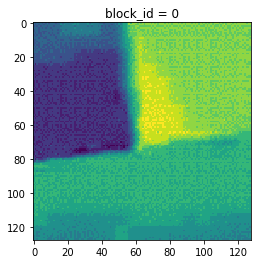

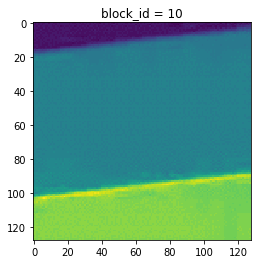

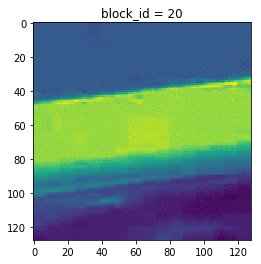

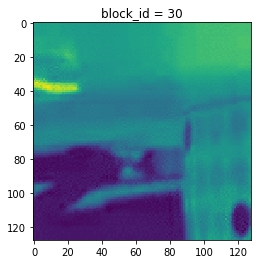

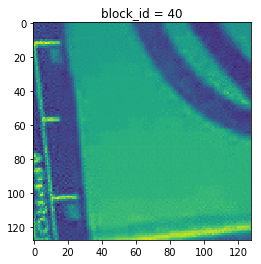

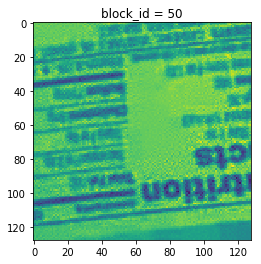

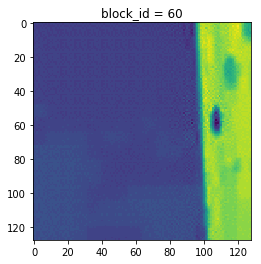

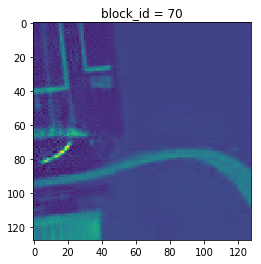

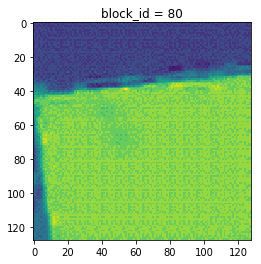

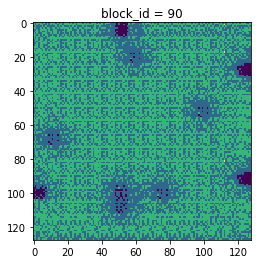

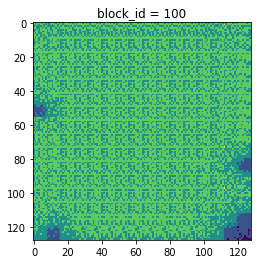

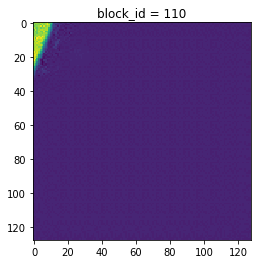

In [4]:
# apply the 8*8 2D-idct on each block
pixel_block = deepcopy(ori_data)
pixel_block = restore_dct_co(pixel_block)
print('The pixel_block is in shape: ' + str(pixel_block.shape))

# show the pixel block
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage.io as imio
for block_id in np.arange(0,n_block, 10):
    implot = plt.imshow(pixel_block[block_id, :, :])
    plt.title('block_id = ' + str(block_id))
    plt.show()

savemat('k2k_predict_pixel.mat', mdict={'k2k_predict_pixel':pixel_block})

255 0


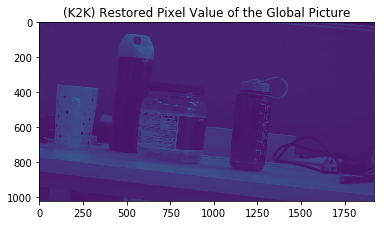

In [5]:
# build the restored global picture
i_max=8
j_max=15
size=i_max*j_max
gl_pre_pxl = np.uint8(np.zeros((i_max * 128, j_max * 128)))
for i in range(0,i_max):
    for j in range(0,j_max):
        gl_pre_pxl [128*i:128*(i+1),128*j:128*(j+1)] = pixel_block[ (j_max*i+j), :, :]
print(np.max(gl_pre_pxl),np.min(gl_pre_pxl))
gl_pre_pxl = np.flip(gl_pre_pxl, 0)
plt.imshow(gl_pre_pxl)
plt.title('(K2K) Restored Pixel Value of the Global Picture')
plt.imsave('(K2K) Restored Pixel Value of the Global Picture', gl_pre_pxl)
savemat('K2K_RestoredPixelValue_Gl', mdict={'K2K_RestoredPixelValue_Gl': gl_pre_pxl})

raw_data is in shape: (120, 128, 128)
255 12


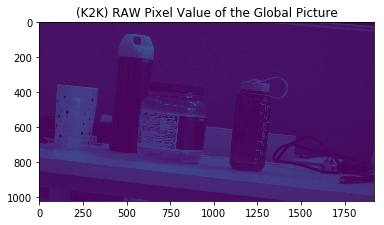

In [6]:
# load and assemble the original Green-channel raw image
# here we define row as width, column as height
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage.io as imio
raw_data = np.load('../test/test_k2k_y.npy')
raw_data = raw_data.reshape(raw_data.shape[0], raw_data.shape[1], raw_data.shape[2])
print('raw_data is in shape: ' + str(raw_data.shape))

raw_data = restore_dct_co(raw_data)

n_block_raw = raw_data.shape[0]
width_block_raw = raw_data.shape[1]
height_block_raw = raw_data.shape[2]

i_max = 8
j_max = 15
gl_raw_pxl = np.uint8(np.zeros((i_max * 128, j_max * 128)))
for i in range(0,i_max):
    for j in range(0,j_max):
        gl_raw_pxl [128*i:128*(i+1),128*j:128*(j+1)] = raw_data[ (j_max*i+j), :, :]

print(np.max(gl_raw_pxl),np.min(gl_raw_pxl))
gl_raw_pxl = np.flip(gl_raw_pxl, 0)  
plt.imshow(gl_raw_pxl)
plt.title('(K2K) RAW Pixel Value of the Global Picture')
plt.imsave('(K2K) RAW Pixel Value of the Global Picture', gl_raw_pxl)

savemat('K2K_RAWPixelValue_Gl', mdict={'K2K_RAWPixelValue_Gl': gl_raw_pxl})
savemat('k2k_raw_image.mat',mdict={'k2k_raw_data': raw_data})

jpg_data is in shape: (120, 128, 128)
255 0


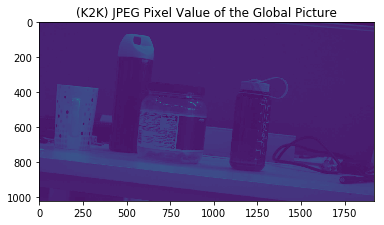

In [7]:
# load and assemble the compressed JPEG image
# here we define row as width, column as height
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage.io as imio
jpg_data = np.load('../test/test_k2k_x.npy')
print('jpg_data is in shape: ' + str(jpg_data.shape))

jpg_data = restore_dct_co(jpg_data)

n_block_jpg = jpg_data.shape[0]
width_block_jpg = jpg_data.shape[1]
height_block_jpg = jpg_data.shape[2]

i_max = 8
j_max = 15
gl_jpg_pxl = np.uint8(np.zeros((i_max * 128, j_max * 128)))
for i in range(0,i_max):
    for j in range(0,j_max):
        gl_jpg_pxl [128*i:128*(i+1),128*j:128*(j+1)] = jpg_data[ (j_max*i+j), :, :]

print(np.max(gl_jpg_pxl),np.min(gl_jpg_pxl))
gl_jpg_pxl = np.flip(gl_jpg_pxl, 0)  
plt.imshow(gl_jpg_pxl)
plt.title('(K2K) JPEG Pixel Value of the Global Picture')
plt.imsave('(K2K) JPEG Pixel Value of the Global Picture', gl_jpg_pxl)

savemat('K2K_JPEGPixelValue_Gl', mdict={'K2K_JPEGPixelValue_Gl': gl_jpg_pxl})
savemat('k2k_jpeg_image.mat',mdict={'k2k_jpg_data': jpg_data})